# Inference

The purpose of this notebook is to allow for evaluation/sampling with a trained NF model

## Setup

In [1]:
# Import packages
import torch
import numpy as np
import normflows as nf

import uproot as up

from matplotlib import pyplot as plot
import math
from tqdm import tqdm
from util import PVect, theta_func, r_func
from IPython.display import clear_output
import time

Using device cuda:0


In [2]:
from reco import process_data, create_dataloader, prepare_data_for_nn, create_dataloader

In [3]:
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import os
def checkdir(path):
    if not os.path.exists(path): 
        os.makedirs(path)

### Load data from .pt file (created by preprocess.py)

## Neural Spline Flow

In [5]:
# Define flows
run_num = 1
run_num_str = str(run_num)

K = 1

latent_size = 1
hidden_units = 100
hidden_layers = 6
context_size = 3
num_context = 3
K_str = str(K)
batch_size= 2000
hidden_units_str = str(hidden_units)
hidden_layers_str = str(hidden_layers)
batch_size_str = str(batch_size)

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
model = model.to(device)


In [6]:
import datetime

x = datetime.datetime.now()
today = x.strftime("%B_%d")
# model_path = "models/context_3/" + today + "/"
# checkdir(model_path)
model_path = "models/" + today + "/"
checkdir(model_path)

samples_path = "data/samples/" + today + "/"
checkdir(samples_path)

test_data_path = "data/test/" + today + "/"
checkdir(test_data_path)

test_dist_path = "plots/test_distributions/" + today + "/"
checkdir(test_dist_path)

In [7]:
model.load(model_path + "run_" + run_num_str + "_" + str(num_context)+ "context_" +K_str +  "flows_" + hidden_layers_str+"hl_" + hidden_units_str+"hu_" + batch_size_str+"bs.pth")

In [8]:
# test_data = torch.load("data/test/July_12/full_test_data_run_1_8flows_4hl_100hu_4000bs.pt")

### Evaluation

In [9]:
# device = 'cpu'

In [10]:
model = model.to(device)

In [17]:
up_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/mu/variation_10kevents_file_11.edm4hep.root:events"
data = process_data(up_path)

In [18]:
features, metadata = prepare_data_for_nn(data)
print("Features shape:", features.shape)
print("Metadata shape:", metadata.shape)

# Create DataLoader
batch_size = 100000
dataloader = create_dataloader(features, metadata, batch_size)

Features shape: (7286862, 5)
Metadata shape: (7286862, 3)


### Resampling inference with dataloader

In [12]:

# min_time = 0
# samples = torch.empty(features.shape[0],device = device)
# it = 0
# begin_time = time.time()
# for batch_features, batch_metadata in dataloader:
#     begin = batch_size * it
#     end = batch_size * (it + 1)
#     # Initialize a mask for valid samples
#     batch_features = batch_features.to(device)
#     valid_samples = torch.zeros(batch_features.shape[0], dtype=torch.bool,device = device)
#     batch_samples = torch.empty(batch_features.shape[0],device = device)
    
#     while not valid_samples.all():
#         # Generate samples for the invalid positions
#         new_samples = model.sample(num_samples=(~valid_samples).sum(), context=batch_features[~valid_samples])[0].squeeze(1)
        
#         # Update the samples and the valid_samples mask
#         batch_samples[~valid_samples] = new_samples
#         valid_samples = batch_samples >= min_time
    
#     samples[begin:end] = batch_samples
#     it += 1
#     if(it >= 0):
#         break
# end_time = time.time()
# samples_cpu = samples.cpu()

In [33]:
batch_features[:,1].unsqueeze(1)

tensor([[7.3989],
        [7.5337],
        [9.8007],
        ...,
        [9.6476],
        [8.1664],
        [9.7466]])

### No resampling

In [39]:

min_time = 0
samples = torch.empty(features.shape[0],device = 'cpu')
it = 0
begin_time = time.time()
for batch_features, batch_metadata in dataloader:
    clear_output(wait=True)
    print(f"Starting batch #{it} out of {72494710 // batch_size} | {(time.time() - begin_time)} seconds elapsed")
    begin = batch_size * it
    end = batch_size * (it + 1)
    # Initialize a mask for valid samples
    context_features = torch.empty(batch_features.shape[0],3)
    context_features[:,0] = batch_features[:,0]
    context_features[:,1] = batch_features[:,2]
    context_features[:,2] = batch_features[:,3]
    context_features = context_features.to(device)
#     batch_samples = model.sample(num_samples=context_features.shape[0], context=context_features)[0].cpu().detach()
#     samples[begin:end] = (batch_samples + batch_features[:,1].unsqueeze(1)).squeeze(1)
    samples[begin:end] = model.sample(num_samples=context_features.shape[0], context=context_features)[0].cpu().detach().squeeze(1)
#     del batch_samples
    del batch_features
    it += 1
    break
end_time = time.time()
samples_cpu = samples.cpu()

Starting batch #0 out of 724 | 1.5975878238677979 seconds elapsed


In [40]:
# delta_t = 1209
delta_t = end_time - begin_time

In [41]:
print(f"Sampling {end} times took {(delta_t)} seconds\n rate: {end / (delta_t)} samples/second")

Sampling 100000 times took 1.6898720264434814 seconds
 rate: 59176.078682396335 samples/second



on gpu - 3500 samples/second with no resampling w/20k batch size

on cpu - 1400 samples/second no resampling w/20k batch size 

on cpu - 1136 samples/second no resampling w/10k batch size

on cpu - 2179 samples/second no resampling w/40k batch size

on gpu - 212 samples/second w resampling

on gpu - 3200 samples/second no resampling w/40k batch size

on gpu - 12000 samples/second no resampling w/80k batch size

on gpu - 5000 samples/second no resampling w/40k batch size

on gpu - 40k samples/second no resampling w/500k batch size

on gpu - 40k samples/second no resampling w/700k batch size

on gpu - 2 flow model - 73k samples/second no resampling w/500k batch size

on gpu - 2 flow model - 74k samples/second no resampling w/1m batch size

on gpu - 1 flow model - 100k samples/second w 2m batch size (july 16 run 1)

##### Below is the histogram of samples (no adding)

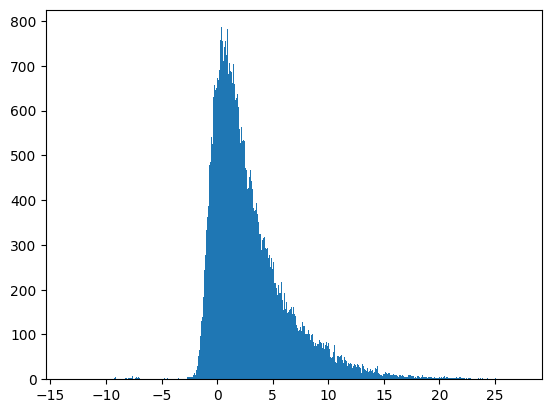

In [42]:
plot.hist(samples_cpu[:end].detach().numpy(),bins = 1000);

##### Below is the histogram of samples when mu hit time added back

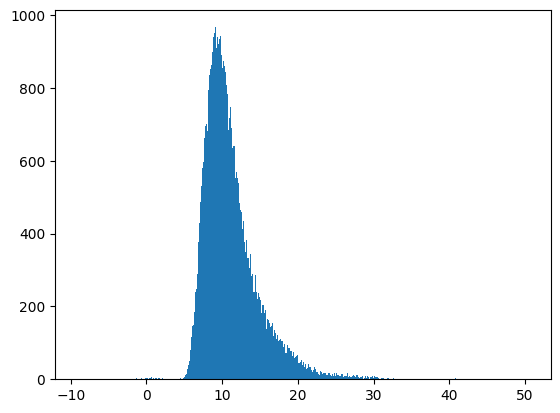

In [37]:
plot.hist(samples_cpu[:end].detach().numpy(),bins = 1000);

In [20]:
num_sim_per_event = 5.47 * 10 ** 7 / 100
dt_sim_per_event = 13
print(f"# photons per event: {num_sim_per_event}")
print(f"# photons simulated per second: {num_sim_per_event / dt_sim_per_event}")

# photons per event: 547000.0
# photons simulated per second: 42076.92307692308


In [7]:
torch.save(samples,"data/samples/July_15/Data/run_5_6_flows_4hl_100hu_4000_bs.pt")
# torch.save(eval_test_data,"data/test/July_12/run_1_8_flows_4hl_100hu_5000_bs.pt")

# samples = torch.load("data/samples/July_11/run_5_6_flows_4hl_100hu_5000_bs.pt")
# eval_test_data = torch.load("data/test/July_11/run_5_6_flows_4hl_100hu_5000_bs.pt")

## Load in and compare to real data

In [ ]:
branch_list = ["HcalBarrelHits.EDep","HcalBarrelHits.pathLength","_HcalBarrelHits_MCParticle.index","_MCParticles_parents.index","MCParticles.daughters_end","MCParticles.PDG","MCParticles.endpoint.x"]
file_dir = f"/cwork/rck32/eic/work_eic/root_files/July_16/"
num_files = len([name for name in os.listdir(file_dir) if not os.path.isdir(name)])
file_names = [name for name in os.listdir(file_dir) if not os.path.isdir(name)]
tree_ext = ":events"
for i in range(num_files):
    if(i == 0):
#             print(f"file_name: {file_names[i]}")
        events = up.open(file_dir + file_names[i] + tree_ext).arrays(branch_list,library="pd")
    else:
        if(not highAff):
            if(i > 6):
                break
        events = pd.concat([events,up.open(file_dir + file_names[i] + tree_ext).arrays(branch_list,library="pd")],ignore_index = True)
